# Convolutional Neural Networks
## Pneumonia Recognition
---
In this notebook, we are going to train a **CNN** to classify X_rays with pneumonia. 

We will be using Pytorch as our framework.

The images in this database are grayscale images that fall into one of two classes: `Normal` or `Pneumonia`. A example is pictured below.

<img src='data/test/Normal/IM-0001-0001.jpeg' width=20% height=20% />

In [1]:
import matplotlib.pyplot as plt

import numpy as np

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.utils.data.sampler import SubsetRandomSampler
import datetime

In [2]:
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print("CUDA isn't available.  Training on CPU ... :(")
else:
    print('CUDA is available!!  Training on GPU ... :)')

CUDA is available!!  Training on GPU ... :)


In [3]:
datapath = 'data/'
batchSize = 20
    
trainTransforms = transforms.Compose([#transforms.RandomRotation(30),
                                       transforms.Resize((120,120)),
                                       #transforms.RandomResizedCrop(92),
                                       #transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor()])
                                       #transforms.Normalize(
                                            #[0.4395, 0.4395, 0.4395],
                                            #[0.0128, 0.0128, 0.0128])])
                                    

testTransforms = transforms.Compose([#transforms.RandomRotation(30),
                                     transforms.Resize((120,120)),
                                     #transforms.RandomResizedCrop(crop),
                                     transforms.ToTensor()])
                                     #transforms.Normalize(
                                     #       [0.4395, 0.4395, 0.4395],
                                     #       [0.0128, 0.0128, 0.0128])])
                                     

# Passing transforms:
trainData = datasets.ImageFolder(datapath + '/train', transform=trainTransforms)
testData = datasets.ImageFolder(datapath + '/test', transform=testTransforms)


# Getting do value of trainData.
trainDataSize = len(trainData)
print(f'Size Total Set: {trainDataSize}')
indices = list(range(trainDataSize))
#Aleatorizando os valores do train size.
np.random.shuffle(indices)

# Separando test and validation data.
validSize = 0.1151
split = int(np.floor(validSize * trainDataSize)) 
print(f'Split on {split} index')

# Separando o trainingset em train and valid using slice.
#train_idx, valid_idx = trainData[split:], indices[:split]
train_idx, valid_idx = indices[split:], indices[:split]
print(f'Size of Train Set: {len(train_idx)}\nSize of validation set: {len(valid_idx)}')

# define samplers for obtaining training and validation batches
trainSampler = SubsetRandomSampler(train_idx)
validSampler = SubsetRandomSampler(valid_idx)

# Carregando Train, Validation and Test data.                                
trainLoader = torch.utils.data.DataLoader(trainData, batch_size=batchSize, sampler=trainSampler)
validLoader = torch.utils.data.DataLoader(trainData, batch_size=batchSize, sampler=validSampler)
testLoader = torch.utils.data.DataLoader(testData, batch_size=batchSize)
print(f'Size of Test Set: {len(testData)}')

classes = ['Normal', 'Pneumonia']

Size Total Set: 5216
Split on 600 index
Size of Train Set: 4616
Size of validation set: 600
Size of Test Set: 640


In [4]:
trainData.class_to_idx

{'Normal': 0, 'Pneumonia': 1}

### Just verifying the the Sets

In [5]:
test  = iter(trainLoader)
x, y = test.next()
print(x.shape)
print(y.shape)

torch.Size([20, 3, 120, 120])
torch.Size([20])


### Show the TestSet images

In [6]:
def imshow(img):
    #img = img / 2  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1])


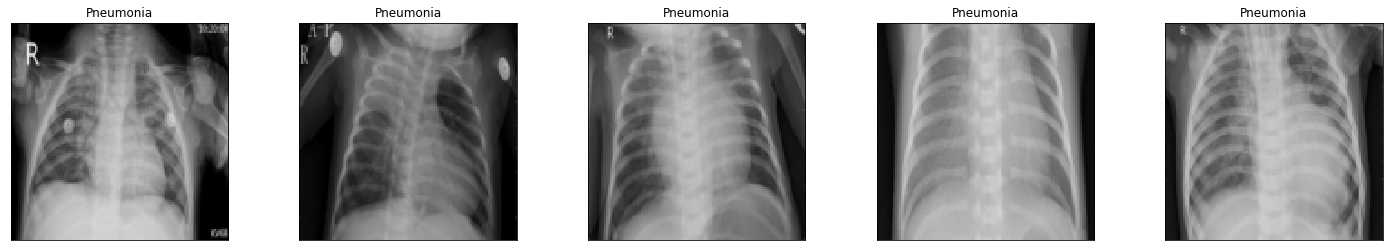

In [7]:
# obtain one batch of training images
dataiter = iter(trainLoader)
images, labels = dataiter.next()
print(labels)

images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))

for idx in np.arange(5):
    ax = fig.add_subplot(1, 5, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])


### Specifying The Architechture

In [8]:
import torch.nn as nn
import torch.nn.functional as F

input_vector = 32*30*30
# 30720
# define the CNN architecture
class Rob(nn.Module):
    def __init__(self):
        super(Rob, self).__init__()
        # convolutional layer
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        #self.conv3 = nn.Conv2d(32, 128, 3, padding=1)
        
        # MLP layers
        self.fc1 = nn.Linear(input_vector, 256)
        self.fc2 = nn.Linear(256,512)
        self.fc3 = nn.Linear(512,1024)
        self.fc4 = nn.Linear(1024,64)
        self.fc5 = nn.Linear(64,2)
        
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.45)
        
    def forward(self, x):
        # add sequence of convolutional and max pooling layers
        x = self.pool(F.relu(self.conv1(x)))
        #x = F.relu(self.conv2(x))
        x = self.pool(F.relu(self.conv2(x)))
        
        # Flattening image to MPL
        x = x.view(-1, input_vector)
        
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        
        x = F.relu(self.fc3(x))
        x = self.dropout(x)

        x = F.relu(self.fc4(x))
        x = self.dropout(x)

        x = self.fc5(x)
        
                
        return x

# create a complete CNN
model = Rob()
print(model)

# move tensors to GPU if CUDA is available
if train_on_gpu:
    model.cuda()

Rob(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=28800, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=1024, bias=True)
  (fc4): Linear(in_features=1024, out_features=64, bias=True)
  (fc5): Linear(in_features=64, out_features=2, bias=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.45, inplace=False)
)


### Specify Loss Function and Optimizer

In [9]:
import torch.optim as optim

# specify loss function
criterion = nn.CrossEntropyLoss()

# optimizer
optimizer = optim.SGD(model.parameters(), lr=0.007)

### Training the Dataset

In [10]:
# number of epochs to train the model
n_epochs = 110 # you may increase this number to train a final model

valid_loss_min = np.Inf # track change in validation loss
t_loss = []
v_loss = []

start = datetime.datetime.now()
print(start)

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    print(f'\nStarting Training epoch: {epoch}', end=' / ')
    model.train()
    for data, target in trainLoader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        #print(output)
        
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)
        
    ######################    
    # validate the model #
    ######################
    print(f'Starting Validation epoch: {epoch}')
    test_loss = 0.0
    class_correct = list(0. for i in range(2))
    class_total = list(0. for i in range(2))
    tp = tn = fp = fn = 0
    #############################
    
    model.eval()
    for data, target in validLoader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        
        output = model(data)
        # calculate the batch loss
        
        loss = criterion(output, target)
       
        # update average validation loss 
        valid_loss += loss.item()*data.size(0)
        #print(output)
        _, pred = torch.max(output, 1)

        # compare predictions to true label
        correct_tensor = pred.eq(target.data.view_as(pred))
        correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
        # calculate test accuracy for each object class

        for i in range(batchSize):
            label = target.data[i]
            #print(f'--{label}')
            if (label == torch.tensor(0) and correct[i].item() == True):
                tn+=1
            elif (label == torch.tensor(0) and correct[i].item() == False):
                fp+=1
            elif (label == torch.tensor(1) and correct[i].item() == True):
                tp+=1
            elif (label == torch.tensor(1) and correct[i].item() == False):
                fn+=1

            class_correct[label] += correct[i].item()
            class_total[label] += 1
######################    
    
    # calculate average losses
    train_loss = train_loss/len(trainLoader.dataset)
    t_loss.append(train_loss)
    
    valid_loss = valid_loss/len(validLoader.dataset)
    v_loss.append(valid_loss)
        
    # print training/validation statistics 
    print(f'\tTraining Loss: {train_loss:.6f} \tValidation Loss: {valid_loss:.6f}')
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print(f'Validation loss decreased ({valid_loss_min:.6f} --> {valid_loss:.6f}). Saving model ...')
        torch.save(model.state_dict(), 'model_Xray.pt')
        valid_loss_min = valid_loss
        
    print(f'\tTrue Pos: {tp} / True Neg: {tn} / False Pos: {fp} / False Neg: {fn}')
        
else:
#    print(output)
#    print(target)
    print(f'Training Loss: {t_loss}')
    print(f'Validation Loss: {v_loss}')
    final = datetime.datetime.now()

2020-02-07 09:47:05.271841

Starting Training epoch: 1 / Starting Validation epoch: 1
	Training Loss: 0.565354 	Validation Loss: 0.067087
Validation loss decreased (inf --> 0.067087). Saving model ...
	True Pos: 450 / True Neg: 0 / False Pos: 150 / False Neg: 0

Starting Training epoch: 2 / Starting Validation epoch: 2
	Training Loss: 0.511565 	Validation Loss: 0.064884
Validation loss decreased (0.067087 --> 0.064884). Saving model ...
	True Pos: 450 / True Neg: 0 / False Pos: 150 / False Neg: 0

Starting Training epoch: 3 / Starting Validation epoch: 3
	Training Loss: 0.507635 	Validation Loss: 0.064716
Validation loss decreased (0.064884 --> 0.064716). Saving model ...
	True Pos: 450 / True Neg: 0 / False Pos: 150 / False Neg: 0

Starting Training epoch: 4 / Starting Validation epoch: 4
	Training Loss: 0.504569 	Validation Loss: 0.064448
Validation loss decreased (0.064716 --> 0.064448). Saving model ...
	True Pos: 450 / True Neg: 0 / False Pos: 150 / False Neg: 0

Starting Training

Starting Training epoch: 38 / Starting Validation epoch: 38
	Training Loss: 0.088702 	Validation Loss: 0.008675
Validation loss decreased (0.009244 --> 0.008675). Saving model ...
	True Pos: 445 / True Neg: 143 / False Pos: 7 / False Neg: 5

Starting Training epoch: 39 / Starting Validation epoch: 39
	Training Loss: 0.087318 	Validation Loss: 0.009066
	True Pos: 441 / True Neg: 142 / False Pos: 8 / False Neg: 9

Starting Training epoch: 40 / Starting Validation epoch: 40
	Training Loss: 0.084904 	Validation Loss: 0.009965
	True Pos: 439 / True Neg: 143 / False Pos: 7 / False Neg: 11

Starting Training epoch: 41 / Starting Validation epoch: 41
	Training Loss: 0.088327 	Validation Loss: 0.009273
	True Pos: 446 / True Neg: 139 / False Pos: 11 / False Neg: 4

Starting Training epoch: 42 / Starting Validation epoch: 42
	Training Loss: 0.081471 	Validation Loss: 0.008727
	True Pos: 443 / True Neg: 141 / False Pos: 9 / False Neg: 7

Starting Training epoch: 43 / Starting Validation epoch: 43


Starting Training epoch: 82 / Starting Validation epoch: 82
	Training Loss: 0.033580 	Validation Loss: 0.007183
Validation loss decreased (0.007624 --> 0.007183). Saving model ...
	True Pos: 445 / True Neg: 144 / False Pos: 6 / False Neg: 5

Starting Training epoch: 83 / Starting Validation epoch: 83
	Training Loss: 0.030814 	Validation Loss: 0.008059
	True Pos: 447 / True Neg: 141 / False Pos: 9 / False Neg: 3

Starting Training epoch: 84 / Starting Validation epoch: 84
	Training Loss: 0.027446 	Validation Loss: 0.009280
	True Pos: 448 / True Neg: 142 / False Pos: 8 / False Neg: 2

Starting Training epoch: 85 / Starting Validation epoch: 85
	Training Loss: 0.024070 	Validation Loss: 0.007720
	True Pos: 445 / True Neg: 144 / False Pos: 6 / False Neg: 5

Starting Training epoch: 86 / Starting Validation epoch: 86
	Training Loss: 0.026887 	Validation Loss: 0.008095
	True Pos: 447 / True Neg: 143 / False Pos: 7 / False Neg: 3

Starting Training epoch: 87 / Starting Validation epoch: 87
	T

KeyboardInterrupt: 

In [ ]:
time_total = final-start
print(f'Total time on training: {time_total}')
print(f'Time per epoch: {time_total/n_epochs}')

### Open the Better model

In [11]:
model.load_state_dict(torch.load('model_Xray.pt',))

<All keys matched successfully>

### Testing the model

In [12]:
test_loss = 0.0
class_correct = list(0. for i in range(2))
class_total = list(0. for i in range(2))
tp = tn = fp = fn = 0

model.eval()
for data, target in testLoader:
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    
    output = model(data)
    loss = criterion(output, target)
    test_loss += loss.item()*data.size(0)
    
    _, pred = torch.max(output, 1)
    
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    
    
    for i in range(batchSize):
        label = target.data[i]
        if (label == torch.tensor(0) and correct[i].item() == True):
            tn+=1
        elif (label == torch.tensor(0) and correct[i].item() == False):
            fp+=1
        elif (label == torch.tensor(1) and correct[i].item() == True):
            tp+=1
        elif (label == torch.tensor(1) and correct[i].item() == False):
            fn+=1
        
        class_correct[label] += correct[i].item()
        class_total[label] += 1

        
        
# average test loss
test_loss = test_loss/len(testLoader.dataset)
print(f'Test Loss: {test_loss:.6f}\n')


for i in range(len(classes)):
    if class_total[i] > 0:
        print(f'''Test Accuracy of {classes[i]}: {int(100*(class_correct[i]/class_total[i]))}%, 
                                {np.sum(class_correct[i]), np.sum(class_total[i])}''')
    else:
        print(f'Test Accuracy of {classes[i]}: N/A (no training examples)')

print(f'''\nTest Accuracy (Overall): \
      {100. * np.sum(class_correct) / np.sum(class_total):.2f}%
      ({np.sum(class_correct)}/{np.sum(class_total)})''')

print(f'''  
True Positive: {tp}
True Negative: {tn}
False Positive: {fp}
False Negative: {fn}''')

pr = tp/(tp+fp)
re = tp/(tp+fn)
f1 = 2*pr*re/(pr+re)
t = tp+tn+fp+fn

print(f'''
      Precision: {pr:.3f}
      Recall: {re:.3f}
      F1: {f1:.3f}
      Accuracy: {(tp+tn)/t} 
      Misclassified: { (fp+fn)/t}''')



Test Loss: 1.428660

Test Accuracy of Normal: 42%, 
                                (103.0, 242.0)
Test Accuracy of Pneumonia: 98%, 
                                (391.0, 398.0)

Test Accuracy (Overall):       77.19%
      (494.0/640.0)
  
True Positive: 391
True Negative: 103
False Positive: 139
False Negative: 7

      Precision: 0.738
      Recall: 0.982
      F1: 0.843
      Accuracy: 0.771875 
      Misclassified: 0.228125
